# Black Litterman with Investor Views Optimization: Oldest Country ETFs
# Charts

## 1. Data Fetching

### Model configuration

In [1]:
import os
import sys
import datetime as dt
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
import cvxportfolio as cp
import alphamodel as am

config = {'name': 'bl_sim_charts',
          'universe':
              {'list': ['SPY', 'EWA', 'EWC', 'EWG', 'EWH', 'EWJ', 'EWS', 'EWU', 'EWW'],
               'ticker_col': 'Symbol',
               'risk_free_symbol': 'USDOLLAR'},
          'data':
              {'name': 'eod_returns',
               'source': 'quandl',
               'table': 'EOD',
               'api_key': "6XyApK2BBj_MraQg2TMD"},
          'model':
              {'start_date': '19970102',
               'end_date': '20091231',
               'halflife': 65,
               'min_periods': 3,
               'hidden_states': 2,
               'train_len': 1700,
               'process': 'none',
               'data_dir': '/Users/razvan/PyRepo/research_masc/data_store/bl/',
               'returns':
                   {'sampling_freq': 'daily'},
               'covariance':
                    {'method' : 'SS',
                     'sampling_freq' : 'monthly',
                     'train_days': 360}
              }
         }

# Logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

/Users/razvan/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### 1.1 Plot standard normal CDF for 2

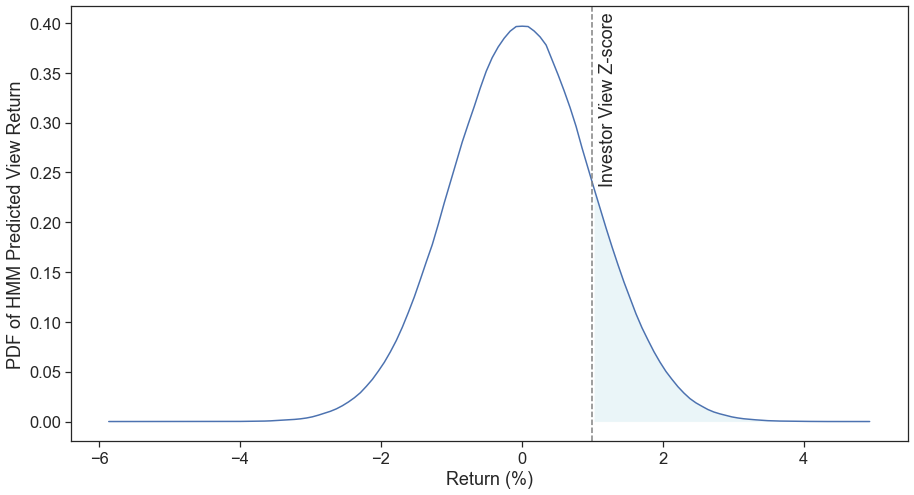

In [76]:
ss = am.SingleStockBLHMM(config)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
dist = np.random.normal(loc=0, scale=1, size=1000000)

plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):
    ax = sns.kdeplot(dist)
    line = ax.get_lines()[-1]
    x, y = line.get_data()
    mask = x >= 1
    x, y = x[mask], y[mask]
    ax.fill_between(x, y1=y, alpha=0.25, facecolor='lightblue')
    
    plt.axvline(x=1, color='gray', linestyle='--')
    plt.text(1.1, 0.24, 'Investor View Z-score', rotation=90)
    
    ax.set(xlabel='Return (%)', ylabel='PDF of HMM Predicted View Return')
    plt.savefig(ss.cfg['data_dir'] + 'bl_view_cdf.png')
    plt.show()

In [78]:
def sigmoid(x, a, b):
    return 1 / (1 + np.exp(-x*a + a*b))
x = [x / 10 for x in range(-50, 50)]
sig = [sigmoid(x, 1, 1) for x in x]

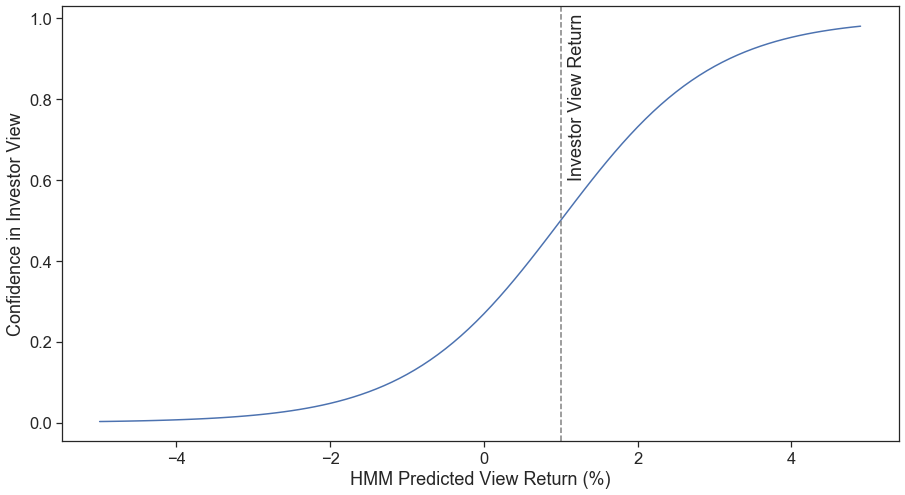

In [79]:
plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)

with sns.axes_style('ticks'):
    ax = sns.lineplot(y=sig, x=x)
    
    plt.axvline(x=1, color='gray', linestyle='--')
    plt.text(1.1, 0.61, 'Investor View Return', rotation=90)
    
    ax.set(xlabel='HMM Predicted View Return (%)', ylabel='Confidence in Investor View')
    plt.savefig(ss.cfg['data_dir'] + 'bl_view_sigmoid.png')
    plt.show()

### 1.2 Fetch return data

In [3]:
# Fetch returns / volumes
ss.train(force=True)

# Realized Data for Simulation
prices = ss.get('prices', 'realized', ss.cfg['returns']['sampling_freq']).iloc[1:,:]
returns = ss.get('returns', 'realized', ss.cfg['returns']['sampling_freq'])
volumes = ss.get('volumes', 'realized', ss.cfg['returns']['sampling_freq'])
sigmas = ss.get('sigmas', 'realized', ss.cfg['returns']['sampling_freq'])

simulated_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., sigma=sigmas, volume=volumes)
simulated_hcost = cp.HcostModel(borrow_costs=0.0001)
simulator = cp.MarketSimulator(returns, costs=[simulated_tcost, simulated_hcost],
                               market_volumes=volumes, cash_key=ss.risk_free_symbol)

downloading SPY from 19970102 to 20091231
downloading EWA from 19970102 to 20091231
downloading EWC from 19970102 to 20091231
downloading EWG from 19970102 to 20091231
downloading EWH from 19970102 to 20091231
downloading EWJ from 19970102 to 20091231
downloading EWS from 19970102 to 20091231
downloading EWU from 19970102 to 20091231
downloading EWW from 19970102 to 20091231
downloading USDOLLAR from 19970102 to 20091231
Removing these days from dataset:
            nan price
1999-04-02          9
2001-09-13          9
2001-09-14          9
2007-01-02          9
2007-04-06          9
          remaining nan price
SPY                         0
EWA                         0
EWC                         0
EWG                         0
EWH                         0
EWJ                         0
EWS                         0
EWU                         0
EWW                         0
USDOLLAR                   25
Proceeding with forward fills to remove remaining NaNs


### 1.3 Plot view return data

In [4]:
# Correct View
correct_view = np.array([-1, 0, 0, 1, 0, 0, 0, 0, 0, 0])
# Incorrect View
incorrect_view = np.array([1, 0, 0, -1, 0, 0, 0, 0, 0, 0])

In [5]:
# Process returns for charting
raw_returns = returns[returns.index >= dt.datetime(2005, 1, 2)]
view_returns = pd.DataFrame.from_dict({'Correct View': np.dot(raw_returns.values, correct_view),
                                       'Incorrect View': np.dot(raw_returns.values, incorrect_view)})
view_returns.index = raw_returns.index
view_growth = (view_returns + 1).cumprod()
view_returns_cum = view_growth - 1
view_returns_cum = view_returns_cum.stack().reset_index()
view_returns_cum.columns = ['Date', 'Ex-Post View', 'Value']

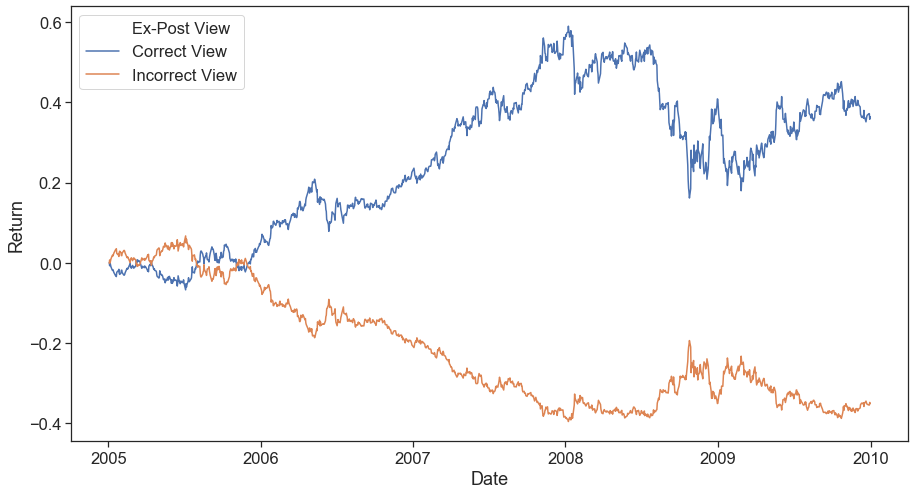

In [80]:
plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):
    data = view_returns_cum
    ax = sns.lineplot(x='Date', y='Value', hue='Ex-Post View', data=data)
    ax.set(xlabel='Date', ylabel='Return')
    ax.legend(loc='upper left')
    plt.savefig(ss.cfg['data_dir'] + 'bl_view_returns.png')

## 2. Model fitting

### 2.1 Extract Black Litterman equilibrium returns

In [7]:
# Aggregate market stats for cal
market_stats = pd.DataFrame({'MarketCap/GDP': [1.25, 1, 1.25, 0.45, 3.5, 0.8, 2, 1.25, 0.3, 0],
                             'GDP': [2543500, 150000, 239000, 853000, 22500, 1037500, 10000, 422500, 164500, 0]},
                            index=ss.universe + ['USDOLLAR'])
market_stats.loc[:, 'MarketCap'] = market_stats.loc[:, 'MarketCap/GDP'] * market_stats.loc[:, 'GDP']
market_stats.loc[:, 'MarketCap Weights'] = market_stats.loc[:, 'MarketCap'] / market_stats.loc[:, 'MarketCap'].sum()
market_stats

,MarketCap/GDP,GDP,MarketCap,MarketCap Weights
SPY,1.25,2543500,3179375.0,0.576162
EWA,1.00,150000,150000.0,0.027183
EWC,1.25,239000,298750.0,0.054139
EWG,0.45,853000,383850.0,0.069561
EWH,3.50,22500,78750.0,0.014271
EWJ,0.80,1037500,830000.0,0.150411
EWS,2.00,10000,20000.0,0.003624
EWU,1.25,422500,528125.0,0.095706
EWW,0.30,164500,49350.0,0.008943
USDOLLAR,0.00,0,0.0,0.000000


In [8]:
# Generate market cap weights pandas.Series
w_mktcap = pd.Series(index=market_stats.index, data=market_stats.loc[:, 'MarketCap Weights'])
w_mktcap['USDOLLAR'] = 0.

### 2.2 Generate BL posterior returns/covariance

In [9]:
# Parameters that match simulations
risk_aversion = 2.5
confidence = 0.8
vconf = 0.7
gamma_risk = 0.1
gamma_trade = 0.1
gamma_hold = 0

#### 2.2.1 Correct View

In [10]:
# Predicted Data for Optimization
# US underperforms Germany 4% per year - correct view
ss.predict(threshold=0.975, mode='t',
           w_market_cap_init=w_mktcap, risk_aversion=risk_aversion, c=confidence,
           P_view=correct_view, Q_view=np.array(0.04 / 252),
           noise_mode='dynamic_sigmoid'
          )

# Black Litterman output
r_cor_pred = ss.get('returns', 'predicted')
covariance_cor_pred = ss.get('covariance', 'predicted')
conf_cor = ss.get('confidence', 'predicted')
volumes_cor_pred = ss.get('volumes', 'predicted')
sigmas_cor_pred = ss.get('sigmas', 'predicted')

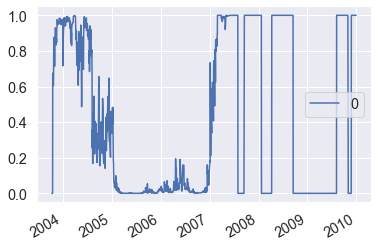

In [11]:
conf_cor.plot()

#### 2.2.2 Incorrect View

In [12]:
# Predicted Data for Optimization
# US outperforms Germany 4% per year - correct view
ss.predict(threshold=0.975, mode='t',
           w_market_cap_init=w_mktcap, risk_aversion=risk_aversion, c=confidence,
           P_view=incorrect_view, Q_view=np.array(0.04 / 252),
           noise_mode='dynamic_sigmoid'
          )

# Black Litterman output
r_incor_pred = ss.get('returns', 'predicted')
covariance_incor_pred = ss.get('covariance', 'predicted')
conf_incor = ss.get('confidence', 'predicted')
volumes_incor_pred = ss.get('volumes', 'predicted')
sigmas_incor_pred = ss.get('sigmas', 'predicted')

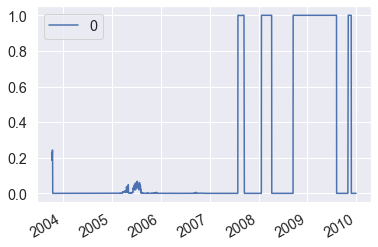

In [13]:
conf_incor.plot()

#### 2.2.3 Plot & Save Confidence Values

In [30]:
confidence = conf_cor.merge(conf_incor, left_index=True, right_index=True)
confidence.loc[:, 'Type'] = 'Sigmoid'
confidence = confidence.reset_index()
confidence.columns = ['Date', 'Correct View', 'Incorrect View', 'Type']
confidence = confidence[confidence.loc[:, 'Date'] >= dt.datetime(2005, 1, 2)]
confidence.to_csv(ss.cfg['data_dir'] + 'bl_view_confidence.csv', index=False, mode='a')
confidence

,Date,Correct View,Incorrect View,Type
311,2005-01-03,0.447072,3.779545e-06,Sigmoid
312,2005-01-04,0.480040,3.310102e-06,Sigmoid
313,2005-01-05,0.389031,4.801212e-06,Sigmoid
314,2005-01-06,0.482563,3.276854e-06,Sigmoid
315,2005-01-07,0.439118,3.903399e-06,Sigmoid
...,...,...,...,...
1565,2009-12-24,1.000000,2.138600e-13,Sigmoid
1566,2009-12-28,1.000000,2.082076e-13,Sigmoid
1567,2009-12-29,1.000000,1.563473e-13,Sigmoid
1568,2009-12-30,1.000000,5.099430e-14,Sigmoid


In [82]:
confidence_all = pd.read_csv(ss.cfg['data_dir'] + 'bl_view_confidence.csv')

confidence_all = confidence_all.set_index(['Date', 'Type']).stack().reset_index()
confidence_all.loc[:, 'Date'] = [dt.datetime.strptime(x, '%Y-%m-%d') for x in confidence_all.loc[:, 'Date']]
confidence_all.columns = ['Date', 'Method', 'Ex-Post View', 'Confidence']
confidence_all

,Date,Method,Ex-Post View,Confidence
0,2005-01-03,CDF,Correct View,4.997948e-01
1,2005-01-03,CDF,Incorrect View,4.879471e-01
2,2005-01-04,CDF,Correct View,4.999222e-01
3,2005-01-04,CDF,Incorrect View,4.877990e-01
4,2005-01-05,CDF,Correct View,4.995558e-01
...,...,...,...,...
5031,2009-12-29,Sigmoid,Incorrect View,1.560000e-13
5032,2009-12-30,Sigmoid,Correct View,1.000000e+00
5033,2009-12-30,Sigmoid,Incorrect View,5.100000e-14
5034,2009-12-31,Sigmoid,Correct View,9.999999e-01


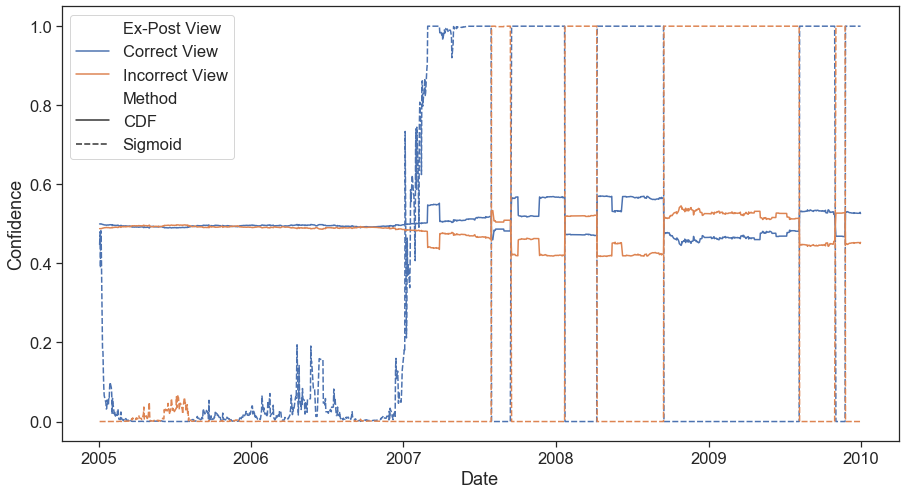

In [84]:
plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):
    data = confidence_all
    sns.lineplot(x='Date', y='Confidence', hue='Ex-Post View', style='Method', data=data)
    ax.set(xlabel='Date', ylabel='Confidence')
    ax.legend(loc='upper left')
    plt.savefig(ss.cfg['data_dir'] + 'bl_view_confidence.png')